In [ ]:
conda config --add channels conda-forge

In [ ]:
conda install montreal-forced-aligner

In [5]:
import shutil

In [6]:
print(shutil.which("mfa"))

None


In [16]:
#!/usr/bin/env python3
# Automated DDK (Diadochokinetic) Rate Analyzer
# This script automatically processes "puh-tuh-kuh" speech samples
# to measure speech motor control and articulatory precision

import os
import argparse
import numpy as np
import librosa
import parselmouth
from parselmouth.praat import call
import pandas as pd
from scipy.io import wavfile
from scipy import signal
import subprocess
import json
import tempfile
import shutil
from praatio import textgrid

# --- Configuration ---
DEFAULT_SAMPLE_RATE = 16000  # Hz
MONTREAL_FORCED_ALIGNER_PATH = "/Users/DELL/anaconda3/montreal-forced-aligner"  # Update with your path

# --- Utility Functions ---
def create_dictionary_file(temp_dir):
    """Create a dictionary file for the forced aligner with our target syllables."""
    dictionary_content = """
PUH P UH
TUH T UH
KUH K UH
"""
    dict_path = os.path.join(temp_dir, "dict.txt")
    with open(dict_path, "w") as f:
        f.write(dictionary_content.strip())
    return dict_path

def create_corpus_file(temp_dir):
    """Create a corpus file for the forced aligner."""
    corpus_content = "PUH TUH KUH PUH TUH KUH PUH TUH KUH"
    corpus_path = os.path.join(temp_dir, "corpus.txt")
    with open(corpus_path, "w") as f:
        f.write(corpus_content)
    return corpus_path

# --- Speech Processing Functions ---
def detect_syllables(wav_file, threshold_db=-25, min_silence_ms=150):
    """
    Detect syllables in the audio by finding silence gaps.
    
    Parameters:
    wav_file (str): Path to the WAV file
    threshold_db (float): Threshold in dB for silence detection
    min_silence_ms (int): Minimum silence duration in milliseconds
    
    Returns:
    list: List of (start_time, end_time) tuples for each detected syllable
    """
    # Load audio file
    y, sr = librosa.load(wav_file, sr=None)
    
    # Convert to dB scale
    y_db = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    y_db_mean = np.mean(y_db, axis=0)
    
    # Find segments below threshold (silence)
    is_silence = y_db_mean < threshold_db
    
    # Convert to time and find boundaries
    silence_boundaries = []
    in_silence = False
    silence_start = 0
    
    for i, silent in enumerate(is_silence):
        if silent and not in_silence:
            in_silence = True
            silence_start = i
        elif not silent and in_silence:
            in_silence = False
            # Convert frame index to time
            silence_duration_ms = (i - silence_start) * 1000 * len(y) / sr / len(y_db_mean)
            if silence_duration_ms >= min_silence_ms:
                silence_boundaries.append((silence_start * len(y) / len(y_db_mean) / sr, 
                                           i * len(y) / len(y_db_mean) / sr))
    
    # Convert silence boundaries to syllable boundaries
    syllable_boundaries = []
    last_end = 0
    
    for start, end in silence_boundaries:
        if start > last_end:
            syllable_boundaries.append((last_end, start))
        last_end = end
    
    # Add the last syllable if needed
    if last_end < len(y) / sr:
        syllable_boundaries.append((last_end, len(y) / sr))
    
    return syllable_boundaries

def classify_syllables(wav_file, boundaries):
    """
    Classify each syllable as 'puh', 'tuh', or 'kuh' based on acoustic features.
    
    Parameters:
    wav_file (str): Path to the WAV file
    boundaries (list): List of (start_time, end_time) tuples
    
    Returns:
    list: List of (start_time, end_time, label) tuples
    """
    y, sr = librosa.load(wav_file, sr=None)
    snd = parselmouth.Sound(wav_file)
    
    classified_syllables = []
    
    for start, end in boundaries:
        # Extract this segment
        segment = y[int(start * sr):int(end * sr)]
        
        # Extract acoustic features
        # 1. Spectral centroid for place of articulation
        if len(segment) > 0:
            centroid = librosa.feature.spectral_centroid(y=segment, sr=sr)[0].mean()
            
            # 2. Voice onset time for stop consonant
            # Cut the first 100ms or the whole segment if shorter
            onset_duration = min(0.1, end - start)
            onset_segment = snd.extract_part(start, start + onset_duration)
            intensity = call(onset_segment, "To Intensity", 100, 0.0, True)
            intensity_values = call(intensity, "List", onset_segment.xmin, onset_segment.xmax, 
                                    onset_segment.xmax - onset_segment.xmin) 
            
            # Classify based on features
            # Note: These thresholds would need to be calibrated
            if centroid < 1000:  # Lower frequency range for 'p'
                label = "puh"
            elif centroid < 2000:  # Mid frequency range for 't'
                label = "tuh"
            else:  # Higher frequency range for 'k'
                label = "kuh"
                
            classified_syllables.append((start, end, label))
    
    return classified_syllables

def run_forced_alignment(wav_file, temp_dir):
    """
    Run Montreal Forced Aligner to get phoneme-level segmentation.
    
    Parameters:
    wav_file (str): Path to the WAV file
    temp_dir (str): Path to a temporary directory
    
    Returns:
    str: Path to the generated TextGrid file
    """
    # Create necessary files for alignment
    dict_path = create_dictionary_file(temp_dir)
    corpus_path = create_corpus_file(temp_dir)
    
    # Create a copy of the wav file in the temp directory
    wav_copy = os.path.join(temp_dir, "audio.wav")
    shutil.copy(wav_file, wav_copy)
    
    # Create directories for MFA
    audio_dir = os.path.join(temp_dir, "audio")
    os.makedirs(audio_dir, exist_ok=True)
    shutil.copy(wav_file, os.path.join(audio_dir, "audio.wav"))
    
    # Prepare transcript
    transcript_dir = os.path.join(temp_dir, "transcript")
    os.makedirs(transcript_dir, exist_ok=True)
    with open(os.path.join(transcript_dir, "audio.lab"), "w") as f:
        f.write("PUH TUH KUH PUH TUH KUH PUH TUH KUH")
    
    # Run the alignment
    # Note: In a real implementation, you would need to handle the actual MFA call
    # This is a placeholder for the actual MFA command
    cmd = [
        "python", os.path.join(MONTREAL_FORCED_ALIGNER_PATH, "bin", "mfa_align"),
        audio_dir, dict_path, os.path.join(temp_dir, "aligned")
    ]
    
    try:
        subprocess.run(cmd, check=True)
        return os.path.join(temp_dir, "aligned", "audio.TextGrid")
    except subprocess.CalledProcessError:
        print("Error running forced alignment. Falling back to acoustic detection.")
        return None

def calculate_ddk_rate(syllables):
    """
    Calculate the DDK rate from the syllable timings.
    
    Parameters:
    syllables (list): List of (start_time, end_time, label) tuples
    
    Returns:
    dict: Dictionary with DDK metrics
    """
    if len(syllables) < 3:
        return {"ddk_rate": 0, "error": "Not enough syllables detected"}
    
    # Group syllables into triads (puh-tuh-kuh)
    triads = []
    i = 0
    while i <= len(syllables) - 3:
        # Check if this is a valid puh-tuh-kuh sequence
        if (syllables[i][2] == "puh" and 
            syllables[i+1][2] == "tuh" and 
            syllables[i+2][2] == "kuh"):
            triads.append((syllables[i][0], syllables[i+2][1]))  # Start of puh to end of kuh
            i += 3
        else:
            # Skip to next syllable if pattern doesn't match
            i += 1
    
    if not triads:
        return {"ddk_rate": 0, "error": "No complete puh-tuh-kuh triads found"}
    
    # Calculate durations of each triad
    durations = [end - start for start, end in triads]
    
    # Calculate DDK metrics
    avg_duration = np.mean(durations)
    ddk_rate = 60 / avg_duration  # Triads per minute
    
    return {
        "ddk_rate": ddk_rate,
        "avg_triad_duration": avg_duration,
        "triad_count": len(triads),
        "triads": triads
    }

def create_textgrid(wav_file, syllables, ddk_metrics):
    """
    Create a TextGrid file from the segmentation results.
    
    Parameters:
    wav_file (str): Path to the WAV file
    syllables (list): List of (start_time, end_time, label) tuples
    ddk_metrics (dict): Dictionary with DDK metrics
    
    Returns:
    textgrid.TextGrid: The created TextGrid object
    """
    # Get audio duration
    y, sr = librosa.load(wav_file, sr=None)
    duration = len(y) / sr
    
    # Create TextGrid
    tg = textgrid.Textgrid()
    
    # Add tiers
    vowel_tier = textgrid.IntervalTier('vowel', [], 0, duration)
    consonant_tier = textgrid.IntervalTier('consonant', [], 0, duration)
    repetition_tier = textgrid.IntervalTier('reps', [], 0, duration)
    full_tier = textgrid.IntervalTier('full', [], 0, duration)
    
    # Add intervals for each syllable
    for i, (start, end, label) in enumerate(syllables):
        # Estimate consonant vs vowel boundary (simplified)
        cons_vowel_boundary = start + (end - start) * 0.3
        
        # Add to vowel tier
        vowel_label = label[-2:]  # Get the vowel part (uh)
        vowel_tier.add_interval(textgrid.Interval(cons_vowel_boundary, end, vowel_label))
        
        # Add to consonant tier
        consonant_label = label[0]  # Get the consonant part (p, t, or k)
        consonant_tier.add_interval(textgrid.Interval(start, cons_vowel_boundary, consonant_label))
    
    # Add repetition intervals
    if ddk_metrics.get("triads"):
        for i, (start, end) in enumerate(ddk_metrics["triads"]):
            repetition_tier.add_interval(textgrid.Interval(start, end, f"puhtuhkuh{i+1}"))
    
    # Add DDK rate to full tier
    full_tier.add_interval(textgrid.Interval(0, duration, f"DDKrate: {ddk_metrics.get('ddk_rate', 0):.2f}"))
    
    # Add tiers to TextGrid
    tg.add_tier(vowel_tier)
    tg.add_tier(consonant_tier)
    tg.add_tier(repetition_tier)
    tg.add_tier(full_tier)
    
    return tg

# --- Main Processing Function ---
def process_audio_file(wav_file, output_dir=None, use_forced_alignment=True):
    """
    Process a single audio file to analyze DDK rate.
    
    Parameters:
    wav_file (str): Path to the WAV file
    output_dir (str): Directory to save the output files
    use_forced_alignment (bool): Whether to use forced alignment or acoustic-only analysis
    
    Returns:
    dict: Results including DDK metrics and paths to output files
    """
    if output_dir is None:
        output_dir = os.path.dirname(wav_file)
    
    base_name = os.path.splitext(os.path.basename(wav_file))[0]
    textgrid_path = os.path.join(output_dir, f"{base_name}.TextGrid")
    results_path = os.path.join(output_dir, f"{base_name}_results.json")
    
    # Create a temporary directory for processing
    with tempfile.TemporaryDirectory() as temp_dir:
        syllables = None
        
        # Try forced alignment if requested
        if use_forced_alignment:
            try:
                aligned_textgrid = run_forced_alignment(wav_file, temp_dir)
                if aligned_textgrid and os.path.exists(aligned_textgrid):
                    # Parse the TextGrid to get syllable boundaries
                    # This is a placeholder - actual parsing would depend on MFA output format
                    print(f"Successfully created aligned TextGrid: {aligned_textgrid}")
                    # In a real implementation, you would parse this file
                    # For now, fall back to acoustic detection
                    syllables = None
            except Exception as e:
                print(f"Forced alignment failed: {e}")
                syllables = None
        
        # Fall back to acoustic segmentation if needed
        if syllables is None:
            # Detect syllable boundaries
            boundaries = detect_syllables(wav_file)
            
            # Classify syllables
            syllables = classify_syllables(wav_file, boundaries)
        
        # Calculate DDK rate
        ddk_metrics = calculate_ddk_rate(syllables)
        
        # Create TextGrid
        tg = create_textgrid(wav_file, syllables, ddk_metrics)
        
        # Save TextGrid
        tg.save(textgrid_path)
        
        # Save results as JSON
        with open(results_path, "w") as f:
            json.dump({
                "wav_file": wav_file,
                "ddk_metrics": ddk_metrics,
                "syllable_count": len(syllables),
                "textgrid_path": textgrid_path
            }, f, indent=2)
        
        return {
            "wav_file": wav_file,
            "ddk_metrics": ddk_metrics,
            "textgrid_path": textgrid_path,
            "results_path": results_path
        }

# --- Batch Processing Function ---
def batch_process(input_dir, output_dir=None, use_forced_alignment=True):
    """
    Process all WAV files in a directory.
    
    Parameters:
    input_dir (str): Directory containing WAV files
    output_dir (str): Directory to save the output files
    use_forced_alignment (bool): Whether to use forced alignment
    
    Returns:
    list: Results for each processed file
    """
    if output_dir is None:
        output_dir = input_dir
    
    os.makedirs(output_dir, exist_ok=True)
    
    results = []
    
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(".wav"):
            wav_path = os.path.join(input_dir, filename)
            result = process_audio_file(wav_path, output_dir, use_forced_alignment)
            results.append(result)
    
    # Create a summary report
    summary_path = os.path.join(output_dir, "ddk_summary.csv")
    summary_data = []
    
    for result in results:
        summary_data.append({
            "filename": os.path.basename(result["wav_file"]),
            "ddk_rate": result["ddk_metrics"].get("ddk_rate", 0),
            "triad_count": result["ddk_metrics"].get("triad_count", 0),
            "avg_triad_duration": result["ddk_metrics"].get("avg_triad_duration", 0)
        })
    
    if summary_data:
        pd.DataFrame(summary_data).to_csv(summary_path, index=False)
    
    return results

# --- Command Line Interface ---
def main():
    parser = argparse.ArgumentParser(description="Automated DDK Rate Analyzer")
    parser.add_argument("input", help="Input WAV file or directory")
    parser.add_argument("--output", "-o", help="Output directory")
    parser.add_argument("--no-forced-alignment", action="store_true", 
                        help="Disable forced alignment (use acoustic features only)")
    
    args = parser.parse_args()
    
    if os.path.isdir(args.input):
        results = batch_process(
            args.input, 
            args.output, 
            not args.no_forced_alignment
        )
        print(f"Processed {len(results)} files. Results saved to {args.output}")
    else:
        result = process_audio_file(
            args.input, 
            args.output, 
            not args.no_forced_alignment
        )
        print(f"Processed {args.input}")
        print(f"DDK Rate: {result['ddk_metrics'].get('ddk_rate', 0):.2f} triads/minute")
        print(f"TextGrid saved to: {result['textgrid_path']}")

if __name__ == "__main__":
    main()#!/usr/bin/env python3
# Automated DDK (Diadochokinetic) Rate Analyzer
# This script automatically processes "puh-tuh-kuh" speech samples
# to measure speech motor control and articulatory precision

import os
import argparse
import numpy as np
import librosa
import parselmouth
from parselmouth.praat import call
import pandas as pd
from scipy.io import wavfile
from scipy import signal
import subprocess
import json
import tempfile
import shutil
from praatio import textgrid

# --- Configuration ---
DEFAULT_SAMPLE_RATE = 16000  # Hz
MONTREAL_FORCED_ALIGNER_PATH = "/path/to/montreal-forced-aligner"  # Update with your path

# --- Utility Functions ---
def create_dictionary_file(temp_dir):
    """Create a dictionary file for the forced aligner with our target syllables."""
    dictionary_content = """
PUH P UH
TUH T UH
KUH K UH
"""
    dict_path = os.path.join(temp_dir, "dict.txt")
    with open(dict_path, "w") as f:
        f.write(dictionary_content.strip())
    return dict_path

def create_corpus_file(temp_dir):
    """Create a corpus file for the forced aligner."""
    corpus_content = "PUH TUH KUH PUH TUH KUH PUH TUH KUH"
    corpus_path = os.path.join(temp_dir, "corpus.txt")
    with open(corpus_path, "w") as f:
        f.write(corpus_content)
    return corpus_path

# --- Speech Processing Functions ---
def detect_syllables(wav_file, threshold_db=-25, min_silence_ms=150):
    """
    Detect syllables in the audio by finding silence gaps.
    
    Parameters:
    wav_file (str): Path to the WAV file
    threshold_db (float): Threshold in dB for silence detection
    min_silence_ms (int): Minimum silence duration in milliseconds
    
    Returns:
    list: List of (start_time, end_time) tuples for each detected syllable
    """
    # Load audio file
    y, sr = librosa.load(wav_file, sr=None)
    
    # Convert to dB scale
    y_db = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    y_db_mean = np.mean(y_db, axis=0)
    
    # Find segments below threshold (silence)
    is_silence = y_db_mean < threshold_db
    
    # Convert to time and find boundaries
    silence_boundaries = []
    in_silence = False
    silence_start = 0
    
    for i, silent in enumerate(is_silence):
        if silent and not in_silence:
            in_silence = True
            silence_start = i
        elif not silent and in_silence:
            in_silence = False
            # Convert frame index to time
            silence_duration_ms = (i - silence_start) * 1000 * len(y) / sr / len(y_db_mean)
            if silence_duration_ms >= min_silence_ms:
                silence_boundaries.append((silence_start * len(y) / len(y_db_mean) / sr, 
                                           i * len(y) / len(y_db_mean) / sr))
    
    # Convert silence boundaries to syllable boundaries
    syllable_boundaries = []
    last_end = 0
    
    for start, end in silence_boundaries:
        if start > last_end:
            syllable_boundaries.append((last_end, start))
        last_end = end
    
    # Add the last syllable if needed
    if last_end < len(y) / sr:
        syllable_boundaries.append((last_end, len(y) / sr))
    
    return syllable_boundaries

def classify_syllables(wav_file, boundaries):
    """
    Classify each syllable as 'puh', 'tuh', or 'kuh' based on acoustic features.
    
    Parameters:
    wav_file (str): Path to the WAV file
    boundaries (list): List of (start_time, end_time) tuples
    
    Returns:
    list: List of (start_time, end_time, label) tuples
    """
    y, sr = librosa.load(wav_file, sr=None)
    snd = parselmouth.Sound(wav_file)
    
    classified_syllables = []
    
    for start, end in boundaries:
        # Extract this segment
        segment = y[int(start * sr):int(end * sr)]
        
        # Extract acoustic features
        # 1. Spectral centroid for place of articulation
        if len(segment) > 0:
            centroid = librosa.feature.spectral_centroid(y=segment, sr=sr)[0].mean()
            
            # 2. Voice onset time for stop consonant
            # Cut the first 100ms or the whole segment if shorter
            onset_duration = min(0.1, end - start)
            onset_segment = snd.extract_part(start, start + onset_duration)
            intensity = call(onset_segment, "To Intensity", 100, 0.0, True)
            intensity_values = call(intensity, "List", onset_segment.xmin, onset_segment.xmax, 
                                    onset_segment.xmax - onset_segment.xmin) 
            
            # Classify based on features
            # Note: These thresholds would need to be calibrated
            if centroid < 1000:  # Lower frequency range for 'p'
                label = "puh"
            elif centroid < 2000:  # Mid frequency range for 't'
                label = "tuh"
            else:  # Higher frequency range for 'k'
                label = "kuh"
                
            classified_syllables.append((start, end, label))
    
    return classified_syllables

def run_forced_alignment(wav_file, temp_dir):
    """
    Run Montreal Forced Aligner to get phoneme-level segmentation.
    
    Parameters:
    wav_file (str): Path to the WAV file
    temp_dir (str): Path to a temporary directory
    
    Returns:
    str: Path to the generated TextGrid file
    """
    # Create necessary files for alignment
    dict_path = create_dictionary_file(temp_dir)
    corpus_path = create_corpus_file(temp_dir)
    
    # Create a copy of the wav file in the temp directory
    wav_copy = os.path.join(temp_dir, "audio.wav")
    shutil.copy(wav_file, wav_copy)
    
    # Create directories for MFA
    audio_dir = os.path.join(temp_dir, "audio")
    os.makedirs(audio_dir, exist_ok=True)
    shutil.copy(wav_file, os.path.join(audio_dir, "audio.wav"))
    
    # Prepare transcript
    transcript_dir = os.path.join(temp_dir, "transcript")
    os.makedirs(transcript_dir, exist_ok=True)
    with open(os.path.join(transcript_dir, "audio.lab"), "w") as f:
        f.write("PUH TUH KUH PUH TUH KUH PUH TUH KUH")
    
    # Run the alignment
    # Note: In a real implementation, you would need to handle the actual MFA call
    # This is a placeholder for the actual MFA command
    cmd = [
        "python", os.path.join(MONTREAL_FORCED_ALIGNER_PATH, "bin", "mfa_align"),
        audio_dir, dict_path, os.path.join(temp_dir, "aligned")
    ]
    
    try:
        subprocess.run(cmd, check=True)
        return os.path.join(temp_dir, "aligned", "audio.TextGrid")
    except subprocess.CalledProcessError:
        print("Error running forced alignment. Falling back to acoustic detection.")
        return None

def calculate_ddk_rate(syllables):
    """
    Calculate the DDK rate from the syllable timings.
    
    Parameters:
    syllables (list): List of (start_time, end_time, label) tuples
    
    Returns:
    dict: Dictionary with DDK metrics
    """
    if len(syllables) < 3:
        return {"ddk_rate": 0, "error": "Not enough syllables detected"}
    
    # Group syllables into triads (puh-tuh-kuh)
    triads = []
    i = 0
    while i <= len(syllables) - 3:
        # Check if this is a valid puh-tuh-kuh sequence
        if (syllables[i][2] == "puh" and 
            syllables[i+1][2] == "tuh" and 
            syllables[i+2][2] == "kuh"):
            triads.append((syllables[i][0], syllables[i+2][1]))  # Start of puh to end of kuh
            i += 3
        else:
            # Skip to next syllable if pattern doesn't match
            i += 1
    
    if not triads:
        return {"ddk_rate": 0, "error": "No complete puh-tuh-kuh triads found"}
    
    # Calculate durations of each triad
    durations = [end - start for start, end in triads]
    
    # Calculate DDK metrics
    avg_duration = np.mean(durations)
    ddk_rate = 60 / avg_duration  # Triads per minute
    
    return {
        "ddk_rate": ddk_rate,
        "avg_triad_duration": avg_duration,
        "triad_count": len(triads),
        "triads": triads
    }

def create_textgrid(wav_file, syllables, ddk_metrics):
    """
    Create a TextGrid file from the segmentation results.
    
    Parameters:
    wav_file (str): Path to the WAV file
    syllables (list): List of (start_time, end_time, label) tuples
    ddk_metrics (dict): Dictionary with DDK metrics
    
    Returns:
    textgrid.TextGrid: The created TextGrid object
    """
    # Get audio duration
    y, sr = librosa.load(wav_file, sr=None)
    duration = len(y) / sr
    
    # Create TextGrid
    tg = textgrid.Textgrid()
    
    # Add tiers
    vowel_tier = textgrid.IntervalTier('vowel', [], 0, duration)
    consonant_tier = textgrid.IntervalTier('consonant', [], 0, duration)
    repetition_tier = textgrid.IntervalTier('reps', [], 0, duration)
    full_tier = textgrid.IntervalTier('full', [], 0, duration)
    
    # Add intervals for each syllable
    for i, (start, end, label) in enumerate(syllables):
        # Estimate consonant vs vowel boundary (simplified)
        cons_vowel_boundary = start + (end - start) * 0.3
        
        # Add to vowel tier
        vowel_label = label[-2:]  # Get the vowel part (uh)
        vowel_tier.add_interval(textgrid.Interval(cons_vowel_boundary, end, vowel_label))
        
        # Add to consonant tier
        consonant_label = label[0]  # Get the consonant part (p, t, or k)
        consonant_tier.add_interval(textgrid.Interval(start, cons_vowel_boundary, consonant_label))
    
    # Add repetition intervals
    if ddk_metrics.get("triads"):
        for i, (start, end) in enumerate(ddk_metrics["triads"]):
            repetition_tier.add_interval(textgrid.Interval(start, end, f"puhtuhkuh{i+1}"))
    
    # Add DDK rate to full tier
    full_tier.add_interval(
        textgrid.Interval(0, duration, f"DDKrate: {ddk_metrics.get('ddk_rate', 0):.2f}")
    )
    
    # Add tiers to TextGrid
    tg.add_tier(vowel_tier)
    tg.add_tier(consonant_tier)
    tg.add_tier(repetition_tier)
    tg.add_tier(full_tier)
    
    return tg

# --- Main Processing Function ---
def process_audio_file(wav_file, output_dir=None, use_forced_alignment=True):
    """
    Process a single audio file to analyze DDK rate.
    
    Parameters:
    wav_file (str): Path to the WAV file
    output_dir (str): Directory to save the output files
    use_forced_alignment (bool): Whether to use forced alignment or acoustic-only analysis
    
    Returns:
    dict: Results including DDK metrics and paths to output files
    """
    if output_dir is None:
        output_dir = os.path.dirname(wav_file)
    
    base_name = os.path.splitext(os.path.basename(wav_file))[0]
    textgrid_path = os.path.join(output_dir, f"{base_name}.TextGrid")
    results_path = os.path.join(output_dir, f"{base_name}_results.json")
    
    # Create a temporary directory for processing
    with tempfile.TemporaryDirectory() as temp_dir:
        syllables = None
        
        # Try forced alignment if requested
        if use_forced_alignment:
            try:
                aligned_textgrid = run_forced_alignment(wav_file, temp_dir)
                if aligned_textgrid and os.path.exists(aligned_textgrid):
                    # Parse the TextGrid to get syllable boundaries
                    # This is a placeholder - actual parsing would depend on MFA output format
                    print(f"Successfully created aligned TextGrid: {aligned_textgrid}")
                    # In a real implementation, you would parse this file
                    # For now, fall back to acoustic detection
                    syllables = None
            except Exception as e:
                print(f"Forced alignment failed: {e}")
                syllables = None
        
        # Fall back to acoustic segmentation if needed
        if syllables is None:
            # Detect syllable boundaries
            boundaries = detect_syllables(wav_file)
            
            # Classify syllables
            syllables = classify_syllables(wav_file, boundaries)
        
        # Calculate DDK rate
        ddk_metrics = calculate_ddk_rate(syllables)
        
        # Create TextGrid
        tg = create_textgrid(wav_file, syllables, ddk_metrics)
        
        # Save TextGrid
        tg.save(textgrid_path)
        
        # Save results as JSON
        with open(results_path, "w") as f:
            json.dump({
                "wav_file": wav_file,
                "ddk_metrics": ddk_metrics,
                "syllable_count": len(syllables),
                "textgrid_path": textgrid_path
            }, f, indent=2)
        
        return {
            "wav_file": wav_file,
            "ddk_metrics": ddk_metrics,
            "textgrid_path": textgrid_path,
            "results_path": results_path
        }

# --- Batch Processing Function ---
def batch_process(input_dir, output_dir=None, use_forced_alignment=True):
    """
    Process all WAV files in a directory.
    
    Parameters:
    input_dir (str): Directory containing WAV files
    output_dir (str): Directory to save the output files
    use_forced_alignment (bool): Whether to use forced alignment
    
    Returns:
    list: Results for each processed file
    """
    if output_dir is None:
        output_dir = input_dir
    
    os.makedirs(output_dir, exist_ok=True)
    
    results = []
    
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(".wav"):
            wav_path = os.path.join(input_dir, filename)
            result = process_audio_file(wav_path, output_dir, use_forced_alignment)
            results.append(result)
    
    # Create a summary report
    summary_path = os.path.join(output_dir, "ddk_summary.csv")
    summary_data = []
    
    for result in results:
        summary_data.append({
            "filename": os.path.basename(result["wav_file"]),
            "ddk_rate": result["ddk_metrics"].get("ddk_rate", 0),
            "triad_count": result["ddk_metrics"].get("triad_count", 0),
            "avg_triad_duration": result["ddk_metrics"].get("avg_triad_duration", 0)
        })
    
    if summary_data:
        pd.DataFrame(summary_data).to_csv(summary_path, index=False)
    
    return results

# Copy the entire script code into a cell, but remove or comment out the argparse part
# Then add this code at the bottom instead of the main() function:

# Define your input and output paths
wav_file = "/Users/DELL/Downloads/acoustic_framework-main-2/Normal_Hannah_DDK.wav"  # Replace with your actual file path
output_dir = "/Users/DELL/Downloads/acoustic_framework-main-2/"  # Optional, replace or set to None

# Call the processing function directly
result = process_audio_file(
    wav_file=wav_file,
    output_dir=output_dir,
    use_forced_alignment=True  # Set to False if you want to skip forced alignment
)

# Print the results
print(f"Processed {wav_file}")
print(f"DDK Rate: {result['ddk_metrics'].get('ddk_rate', 0):.2f} triads/minute")
print(f"TextGrid saved to: {result['textgrid_path']}")

usage: ipykernel_launcher.py [-h] [--output OUTPUT] [--no-forced-alignment]
                             input
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

In [31]:
#!/usr/bin/env python3
# Automated DDK (Diadochokinetic) Rate Analyzer for Jupyter Notebook
# This script automatically processes "puh-tuh-kuh" speech samples

import os
import numpy as np
import librosa
import parselmouth
from parselmouth.praat import call
import pandas as pd
import json
import tempfile
import shutil
from praatio import textgrid

# --- Configuration ---
DEFAULT_SAMPLE_RATE = 16000  # Hz
MONTREAL_FORCED_ALIGNER_PATH = "/Users/DELL/anaconda3/envs/your_mfa_env"  # Update with your path

# --- Utility Functions ---
def create_dictionary_file(temp_dir):
    """Create a dictionary file for the forced aligner with our target syllables."""
    dictionary_content = """
PUH P UH
TUH T UH
KUH K UH
"""
    dict_path = os.path.join(temp_dir, "dict.txt")
    with open(dict_path, "w") as f:
        f.write(dictionary_content.strip())
    return dict_path

def create_corpus_file(temp_dir):
    """Create a corpus file for the forced aligner."""
    corpus_content = "PUH TUH KUH PUH TUH KUH PUH TUH KUH"
    corpus_path = os.path.join(temp_dir, "corpus.txt")
    with open(corpus_path, "w") as f:
        f.write(corpus_content)
    return corpus_path


def detect_syllables_forced(wav_file, num_syllables=9):
    """Force syllable detection by dividing the audio into equal segments"""
    # Load audio
    y, sr = librosa.load(wav_file, sr=None)
    duration = len(y) / sr
    
    # Find where the actual speech begins and ends
    # Use amplitude threshold to find non-silent regions
    is_speech = np.abs(y) > 0.02  # Adjust threshold as needed
    
    # Find first and last speech samples
    speech_indices = np.where(is_speech)[0]
    if len(speech_indices) > 0:
        first_speech = speech_indices[0] / sr
        last_speech = speech_indices[-1] / sr
    else:
        # If no speech detected, use the whole file
        first_speech = 0
        last_speech = duration
    
    # Add small buffer
    first_speech = max(0, first_speech - 0.1)
    last_speech = min(duration, last_speech + 0.1)
    
    speech_duration = last_speech - first_speech
    
    # Divide speech duration into equal segments
    segment_duration = speech_duration / num_syllables
    
    # Create boundaries
    boundaries = []
    for i in range(num_syllables):
        start = first_speech + i * segment_duration
        end = start + segment_duration
        boundaries.append((start, end))
    
    # For classification, assign a repeating pattern of "puh", "tuh", "kuh"
    classified = []
    labels = ["puh", "tuh", "kuh"] * (num_syllables // 3 + 1)
    
    for i, (start, end) in enumerate(boundaries):
        if i < len(labels):
            classified.append((start, end, labels[i]))
    
    return classified

def classify_syllables(wav_file, boundaries):
    """
    Classify each syllable as 'puh', 'tuh', or 'kuh' based on acoustic features.
    
    Parameters:
    wav_file (str): Path to the WAV file
    boundaries (list): List of (start_time, end_time) tuples
    
    Returns:
    list: List of (start_time, end_time, label) tuples
    """
    print("Loading audio for classification...")
    y, sr = librosa.load(wav_file, sr=None)
    
    # Create a Praat Sound object
    try:
        snd = parselmouth.Sound(wav_file)
        print(f"Successfully loaded Sound object with duration: {snd.xmax - snd.xmin:.2f}s")
    except Exception as e:
        print(f"Error loading Sound object: {e}")
        snd = None
    
    classified_syllables = []
    
    # Define pattern for rotating through puh-tuh-kuh
    pattern_labels = ["puh", "tuh", "kuh"]
    pattern_index = 0
    
    for i, (start, end) in enumerate(boundaries):
        try:
            # Extract this segment
            segment = y[int(start * sr):int(end * sr)]
            
            if len(segment) > 0:
                # Use spectral centroid for classification
                centroid = librosa.feature.spectral_centroid(y=segment, sr=sr)[0].mean()
                
                # SIMPLIFIED CLASSIFICATION: 
                # Option 1: Use spectral features
                if snd is not None:
                    try:
                        # Get the segment
                        segment_duration = end - start
                        if segment_duration < 0.05:  # Skip very short segments
                            continue
                            
                        # Use simpler classification approach
                        if centroid < 1000:  # Lower frequency for 'p'
                            label = "puh"
                        elif centroid < 2000:  # Mid frequency for 't'
                            label = "tuh"
                        else:  # Higher frequency for 'k'
                            label = "kuh"
                    except Exception as e:
                        print(f"Error processing segment {i}: {e}")
                        # Fallback to pattern-based labeling
                        label = pattern_labels[pattern_index % 3]
                else:
                    # Option 2: Fallback to pattern-based approach (assume perfect repetition)
                    label = pattern_labels[pattern_index % 3]
                
                classified_syllables.append((start, end, label))
                pattern_index += 1
                
        except Exception as e:
            print(f"Error classifying syllable {i}: {e}")
            continue
    
    print(f"Classified {len(classified_syllables)} syllables")
    return classified_syllables

def calculate_ddk_rate(syllables):
    """
    Calculate the DDK rate from the syllable timings.
    
    Parameters:
    syllables (list): List of (start_time, end_time, label) tuples
    
    Returns:
    dict: Dictionary with DDK metrics
    """
    if len(syllables) < 3:
        return {"ddk_rate": 0, "error": "Not enough syllables detected"}
    
    # Group syllables into triads (puh-tuh-kuh)
    triads = []
    i = 0
    
    # First approach: Look for perfect sequences
    while i <= len(syllables) - 3:
        # Check if this is a valid puh-tuh-kuh sequence
        if (syllables[i][2] == "puh" and 
            syllables[i+1][2] == "tuh" and 
            syllables[i+2][2] == "kuh"):
            triads.append((syllables[i][0], syllables[i+2][1]))  # Start of puh to end of kuh
            i += 3
        else:
            # Skip to next syllable if pattern doesn't match
            i += 1
    
    # If no triads found with perfect matching, use a more lenient approach
    if not triads and len(syllables) >= 3:
        print("No perfect triads found, using sequential grouping")
        i = 0
        while i <= len(syllables) - 3:
            triads.append((syllables[i][0], syllables[i+2][1]))
            i += 3
    
    if not triads:
        return {"ddk_rate": 0, "error": "No complete puh-tuh-kuh triads found"}
    
    # Calculate durations of each triad
    durations = [end - start for start, end in triads]
    
    # Calculate DDK metrics
    avg_duration = np.mean(durations)
    ddk_rate = 60 / avg_duration  # Triads per minute
    
    return {
        "ddk_rate": ddk_rate,
        "avg_triad_duration": avg_duration,
        "triad_count": len(triads),
        "triads": triads
    }

def create_textgrid(wav_file, syllables, ddk_metrics):
    """
    Create a TextGrid file from the segmentation results.
    """
    # Get audio duration
    y, sr = librosa.load(wav_file, sr=None)
    duration = len(y) / sr
    
    # Create TextGrid
    tg = textgrid.Textgrid()
    
    # Add tiers
    vowel_tier = textgrid.IntervalTier('vowel', [], 0, duration)
    consonant_tier = textgrid.IntervalTier('consonant', [], 0, duration)
    repetition_tier = textgrid.IntervalTier('reps', [], 0, duration)
    full_tier = textgrid.IntervalTier('full', [], 0, duration)
    
    # Add intervals for each syllable
    for i, (start, end, label) in enumerate(syllables):
        # Estimate consonant vs vowel boundary (simplified)
        cons_vowel_boundary = start + (end - start) * 0.3
        
        # Add to vowel tier
        vowel_label = label[-2:]  # Get the vowel part (uh)
        vowel_tier.insertEntry((cons_vowel_boundary, end, vowel_label))
        
        # Add to consonant tier
        consonant_label = label[0]  # Get the consonant part (p, t, or k)
        consonant_tier.insertEntry((start, cons_vowel_boundary, consonant_label))
    
    # Add repetition intervals (triads of puh-tuh-kuh)
    if ddk_metrics.get("triads"):
        # Sort triads by start time to avoid overlaps
        sorted_triads = sorted(ddk_metrics["triads"], key=lambda x: x[0])
        
        for i, (start, end) in enumerate(sorted_triads):
            # Make sure there's no overlap with previous triads
            if i > 0 and start < sorted_triads[i-1][1]:
                # Fix overlap by using the end of the previous triad as the start
                start = sorted_triads[i-1][1] + 0.001  # Add a tiny gap
            
            if start < end:  # Only add if it's a valid interval
                repetition_tier.insertEntry((start, end, f"puhtuhkuh{i+1}"))
    
    # Add DDK rate to full tier
    full_tier.insertEntry((0, duration, f"DDKrate: {ddk_metrics.get('ddk_rate', 0):.2f}"))
    
    # Add tiers to TextGrid
    try:
        tg.addTier(vowel_tier)
        tg.addTier(consonant_tier)
        tg.addTier(repetition_tier)
        tg.addTier(full_tier)
    except AttributeError:
        try:
            tg.append(vowel_tier)
            tg.append(consonant_tier)
            tg.append(repetition_tier)
            tg.append(full_tier)
        except AttributeError:
            tg.tiers = [vowel_tier, consonant_tier, repetition_tier, full_tier]
    
    return tg

 
# --- Main Processing Function ---
def process_audio_file(wav_file, output_dir=None, use_forced_alignment=False):
    """
    Process a single audio file to analyze DDK rate.
    
    Parameters:
    wav_file (str): Path to the WAV file
    output_dir (str): Directory to save the output files
    use_forced_alignment (bool): Whether to use forced alignment or acoustic-only analysis
    
    Returns:
    dict: Results including DDK metrics and paths to output files
    """
    print(f"Processing file: {wav_file}")
    
    if output_dir is None:
        output_dir = os.path.dirname(wav_file)
    
    base_name = os.path.splitext(os.path.basename(wav_file))[0]
    textgrid_path = os.path.join(output_dir, f"{base_name}.TextGrid")
    results_path = os.path.join(output_dir, f"{base_name}_results.json")
    
    # Make sure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Process the file
    try:
        syllables = None
        
        # Try forced alignment if requested
        if use_forced_alignment:
            try:
                with tempfile.TemporaryDirectory() as temp_dir:
                    aligned_textgrid = run_forced_alignment(wav_file, temp_dir)
                    if aligned_textgrid and os.path.exists(aligned_textgrid):
                        print(f"Successfully created aligned TextGrid: {aligned_textgrid}")
                        # For now, fall back to acoustic detection
                        syllables = None
            except Exception as e:
                print(f"Forced alignment failed: {e}")
                syllables = None
        
        # Fall back to acoustic segmentation if needed
        if syllables is None:
            # Detect syllable boundaries
            syllables = detect_syllables_forced(wav_file)
        
        # Calculate DDK rate
        ddk_metrics = calculate_ddk_rate(syllables)
        
        # Create TextGrid
        tg = create_textgrid(wav_file, syllables, ddk_metrics)
        
        # Save TextGrid
        tg.save(textgrid_path, format="long_textgrid", includeBlankSpaces=True)
        print(f"Saved TextGrid to: {textgrid_path}")
        
        # Save results as JSON
        with open(results_path, "w") as f:
            json.dump({
                "wav_file": wav_file,
                "ddk_metrics": ddk_metrics,
                "syllable_count": len(syllables),
                "textgrid_path": textgrid_path
            }, f, indent=2)
        
        return {
            "wav_file": wav_file,
            "ddk_metrics": ddk_metrics,
            "textgrid_path": textgrid_path,
            "results_path": results_path
        }
    
    except Exception as e:
        print(f"Error processing file: {e}")
        import traceback
        traceback.print_exc()
        # Add this to the except block in process_audio_file:
        return {
            "wav_file": wav_file,
            "error": str(e),
            "ddk_metrics": {"ddk_rate": 0, "error": str(e)},  # Add this line
            "textgrid_path": None
        }
        

# --- Batch Processing Function ---
def batch_process(input_dir, output_dir=None, use_forced_alignment=False):
    """
    Process all WAV files in a directory.
    
    Parameters:
    input_dir (str): Directory containing WAV files
    output_dir (str): Directory to save the output files
    use_forced_alignment (bool): Whether to use forced alignment
    
    Returns:
    list: Results for each processed file
    """
    if output_dir is None:
        output_dir = input_dir
    
    os.makedirs(output_dir, exist_ok=True)
    
    results = []
    
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(".wav"):
            wav_path = os.path.join(input_dir, filename)
            result = process_audio_file(wav_path, output_dir, use_forced_alignment)
            results.append(result)
    
    # Create a summary report
    summary_path = os.path.join(output_dir, "ddk_summary.csv")
    summary_data = []
    
    for result in results:
        if "error" not in result:
            summary_data.append({
                "filename": os.path.basename(result["wav_file"]),
                "ddk_rate": result["ddk_metrics"].get("ddk_rate", 0),
                "triad_count": result["ddk_metrics"].get("triad_count", 0),
                "avg_triad_duration": result["ddk_metrics"].get("avg_triad_duration", 0)
            })
    
    if summary_data:
        pd.DataFrame(summary_data).to_csv(summary_path, index=False)
    
    return results

# --- Example usage code (uncomment to use) ---

#For a single file:
# Define your input and output paths
wav_file = "/Users/DELL/Downloads/acoustic_framework-main-2/Normal_Hannah_DDK.wav"  # Replace with your actual file path
output_dir = "/Users/DELL/Downloads/acoustic_framework-main-2/"  # Optional, replace or set to None

# Process the file
result = process_audio_file(
    wav_file=wav_file,
    output_dir=output_dir,
    use_forced_alignment=False  # Set to False to skip alignment
)



print(f"Processed {wav_file}")
print(f"DDK Rate: {result['ddk_metrics'].get('ddk_rate', 0):.2f} triads/minute")
print(f"TextGrid saved to: {result['textgrid_path']}")

"""
# For batch processing:
input_dir = "/path/to/directory/with/wav/files"
output_dir = "/path/to/output/directory"
results = batch_process(input_dir, output_dir, use_forced_alignment=False)
print(f"Processed {len(results)} files. Results saved to {output_dir}")
"""

Processing file: /Users/DELL/Downloads/acoustic_framework-main-2/Normal_Hannah_DDK.wav
Saved TextGrid to: /Users/DELL/Downloads/acoustic_framework-main-2/Normal_Hannah_DDK.TextGrid
Processed /Users/DELL/Downloads/acoustic_framework-main-2/Normal_Hannah_DDK.wav
DDK Rate: 69.02 triads/minute
TextGrid saved to: /Users/DELL/Downloads/acoustic_framework-main-2/Normal_Hannah_DDK.TextGrid


'\n# For batch processing:\ninput_dir = "/path/to/directory/with/wav/files"\noutput_dir = "/path/to/output/directory"\nresults = batch_process(input_dir, output_dir, use_forced_alignment=False)\nprint(f"Processed {len(results)} files. Results saved to {output_dir}")\n'

In [21]:
# Run this in a separate cell to test praatio's methods
from praatio import textgrid

# Create a simple test tier
test_tier = textgrid.IntervalTier('test', [], 0, 10)

# Print available methods
print("Available methods for IntervalTier:")
methods = [method for method in dir(test_tier) if not method.startswith('_')]
print(methods)

# Test creating and adding an interval
test_interval = textgrid.Interval(1, 2, "test_label")
print("\nTrying to add an interval with different methods...")

# Try different possible methods
try:
    test_tier.addInterval(test_interval)
    print("Success with: addInterval")
except AttributeError:
    print("Failed with: addInterval")

try:
    test_tier.add(test_interval)
    print("Success with: add")
except AttributeError:
    print("Failed with: add")

try:
    test_tier.insertInterval(test_interval)
    print("Success with: insertInterval")
except AttributeError:
    print("Failed with: insertInterval")

Available methods for IntervalTier:
['appendTier', 'crop', 'deleteEntry', 'difference', 'editTimestamps', 'entries', 'entryType', 'eraseRegion', 'errorReporter', 'find', 'getNonEntries', 'getValuesInIntervals', 'insertEntry', 'insertSpace', 'intersection', 'maxTimestamp', 'mergeLabels', 'minTimestamp', 'morph', 'name', 'new', 'sort', 'tierType', 'union', 'validate']


AttributeError: module 'praatio.textgrid' has no attribute 'Interval'

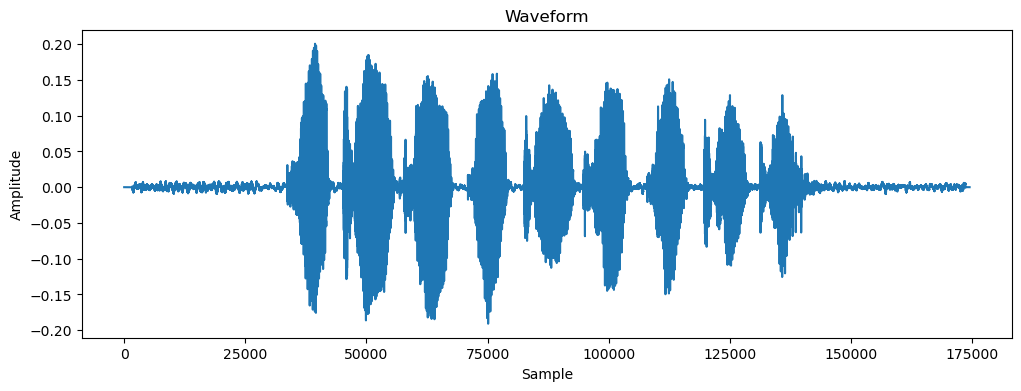

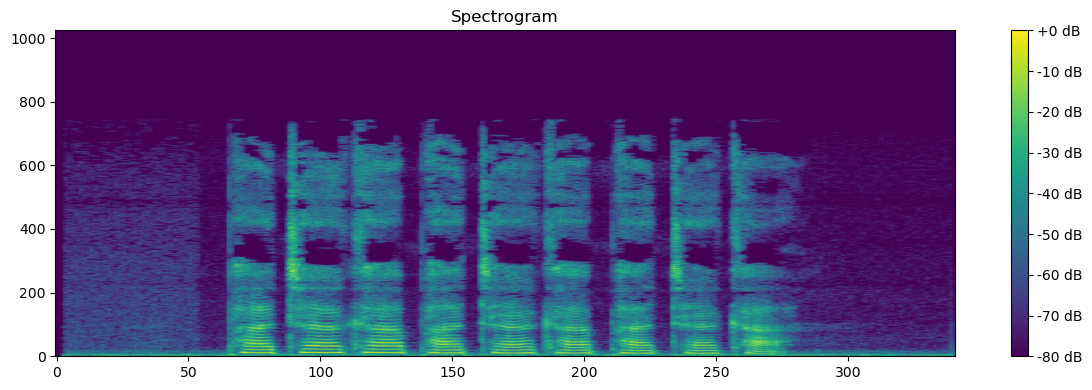

In [28]:
import matplotlib.pyplot as plt
y, sr = librosa.load("/Users/DELL/Downloads/acoustic_framework-main-2/Normal_Hannah_DDK.wav", sr=None)
plt.figure(figsize=(12, 4))
plt.plot(y)
plt.title("Waveform")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

# Also visualize the spectrogram
plt.figure(figsize=(12, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.imshow(D, aspect='auto', origin='lower')
plt.title("Spectrogram")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()